This notebook contains the source code for salty. Usage examples are below

<a id='top'></a>

# Contents

[load datasets](#load datasets)

[create histogram of selected features](#histogram)

[train lasso](#lasso)

[train multi-layer perceptron (MLP) regressor](#nn)

[create static files](#static)

In [2]:
import statistics
import pickle
import salty
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from scipy import stats
from scipy.stats import uniform as sp_rand
from scipy.stats import mode
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
import os
import sys
import pandas as pd
from collections import OrderedDict
from numpy.random import randint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from math import log
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

class dev_model():
    def __init__(self, coef_data, data):
        self.Coef_data = coef_data
        self.Data = data

<a id='load datasets'></a>

# Optimize LASSO (alpha hyperparameter)

[back to top](#top)

In [3]:
property_model = "viscosity"
df = pd.DataFrame.from_csv('../salty/data/%s_premodel.csv' % property_model, index_col=None)
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
cols = dataDf.columns.tolist()
instance = StandardScaler()
data = pd.DataFrame(instance.fit_transform(dataDf), columns=cols[:])
df = pd.concat([data, metaDf], axis=1)
mean_std_of_coeffs = pd.DataFrame([instance.mean_,instance.scale_], columns=cols[:])
viscosity_devmodel = dev_model(mean_std_of_coeffs, df)
pickle_out = open("../salty/data/%s_devmodel.pkl" % property_model, "wb")
pickle.dump(viscosity_devmodel, pickle_out)
pickle_out.close()

In [5]:
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
X_train = dataDf.values
Y_train = metaDf["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))

In [8]:
param_grid = {"alpha": sp_rand(0,0.1), "hidden_layer_sizes" : [randint(10)]}
model = MLPRegressor(max_iter=1000,tol=1e-8)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1,\
                         n_iter=10)
grid_result = grid.fit(X_train, Y_train)
print(grid_result.best_estimator_)

MLPRegressor(activation='relu', alpha=0.047294795300874506, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=7, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [10]:
param_grid = {"alpha": sp_rand(0,0.1)}
model = Lasso(max_iter=1000,tol=1e-8)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1,\
                         n_iter=10)
grid_result = grid.fit(X_train, Y_train)
print(grid_result.best_estimator_)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: 

Lasso(alpha=0.042997015754349423, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=1e-08, warm_start=False)


<a id='ci_coeff'></a>

# Determine Confidence Intervals for LASSO Coefficients

[back to top](#top)

In [12]:
iterations=20
averages=np.zeros(iterations)
variances=np.zeros(iterations)
test_MSE_array=[]

property_model = "viscosity"
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
df = df.sample(frac=1)
df["Viscosity, Pas"] = df["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))
metadf = df.select_dtypes(include=["object"])
datadf = df.select_dtypes(include=[np.number])

          
data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train
deslist=datadf.columns
score=np.zeros(len(datadf.columns))
feature_coefficients=np.zeros((len(datadf.columns),iterations))
test_MSE_array=[]
model_intercept_array=[]
for i in range(iterations):
    data = np.random.permutation(data) 
    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))

    ###sample from training set with replacement
    for k in range(n_train):
        x = randint(0,n_train)
        X_train[k] = data[x,:-1]
        Y_train[k] = (float(data[x,-1]))
    n = data.shape[0]
    ###sample from test set with replacement
    for k in range(n_test):
        x = randint(n_train,n)
        X_test[k] = data[x,:-1]
        Y_test[k] = (float(data[x,-1]))

    ###train the lasso model    
    model = Lasso(alpha=0.04,tol=1e-10,max_iter=4000)
    model.fit(X_train,Y_train)
    
    ###Check what features are selected
    p=0
    avg_size=[]
    for a in range(len(data[0])-1):
        if model.coef_[a] != 0:
            score[a] = score[a] + 1
            feature_coefficients[a,i] = model.coef_[a] ###append the model coefs 
            p+=1
    avg_size.append(p)
    
    ###Calculate the test set MSE
    Y_hat = model.predict(X_test)
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    test_MSE_array.append(test_MSE)
    
    ###Grab intercepts
    model_intercept_array.append(model.intercept_)
    
print(np.average(avg_size))
print(np.average(model_intercept_array))
print(np.average(test_MSE_array))
print(np.std(test_MSE_array))
select_score=[]
select_deslist=[]
feature_coefficient_averages=[]
feature_coefficient_variance=[]
feature_coefficients_all=[]
for a in range(len(deslist)):
    if score[a] != 0:
        select_score.append(score[a])
        select_deslist.append(deslist[a])
        feature_coefficient_averages.append(np.average(feature_coefficients[a,:]))
        feature_coefficient_variance.append(np.std(feature_coefficients[a,:]))
        feature_coefficients_all.append(feature_coefficients[a,:])

32.0
-2.72057192147
2.01816104063
0.144650177504


In [14]:
np.save("LASSOSelectionScores", select_score)
np.save("LASSOSelectionList", select_deslist)
df = pd.DataFrame(select_score, select_deslist)
df.sort_values(by=0, ascending=False)#[:80]

,0
BalabanJ-anion,20.0
SMR_VSA9-anion,20.0
VSA_EState9-cation,20.0
EState_VSA10-cation,20.0
EState_VSA8-cation,20.0
EState_VSA2-cation,20.0
SlogP_VSA7-cation,20.0
SMR_VSA2-cation,20.0
PEOE_VSA14-cation,20.0
NumHAcceptors-cation,20.0


In [15]:
df = pd.DataFrame(data=np.array(feature_coefficients_all).T, columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("bootstrap_coefficients")

In [16]:
df = pd.DataFrame(data=[feature_coefficient_averages,\
                   feature_coefficient_variance], columns=select_deslist)
df = df.T.sort_values(by=1, ascending=False)
df.to_pickle("bootstrap_coefficient_estimates")

In [17]:
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False).iloc[:]
cols = df.T.columns.tolist()
df = pd.read_pickle('bootstrap_coefficient_estimates')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf.to_pickle('bootstrap_coefficient_estimates_top_sorted')

VSA_EState9-cation     0.312843
PEOE_VSA9-anion        0.180814
EState_VSA2-anion      0.177168
SMR_VSA9-anion         0.176223
SMR_VSA2-cation        0.171379
Pressure, kPa          0.166972
SlogP_VSA8-anion       0.136577
PEOE_VSA14-cation      0.127106
RingCount-anion        0.095719
HallKierAlpha-anion    0.091849
BalabanJ-anion         0.089771
dtype: float64


([<matplotlib.axis.XTick at 0x7f8bba197400>,
 <a list of 6 Text xticklabel objects>)

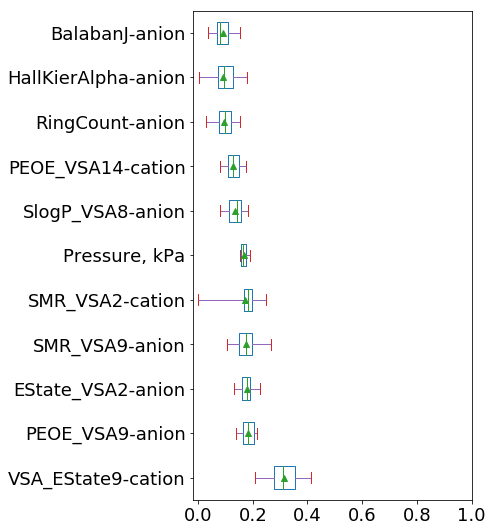

In [18]:
model = pd.read_pickle('bootstrap_coefficient_estimates_top_sorted')
model2 = model.abs()
df = model2.T.sort_values(by=0, ascending=False).iloc[:11]
cols = df.T.columns.tolist()

df = pd.read_pickle('bootstrap_coefficients')
df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
newdf = newdf.replace(0, np.nan)
props = dict(boxes=tableau20[0], whiskers=tableau20[8], medians=tableau20[4],\
             caps=tableau20[6])
print(newdf.abs().mean())
newdf.abs().plot(kind='box', figsize=(5,9), subplots=False, fontsize=18,\
        showmeans=True, logy=False, sharey=True, sharex=True, whis='range', showfliers=False,\
        color=props,  vert=False)
plt.xticks(np.arange(0,1.1,0.2))
# plt.savefig(filename='paper_images/Box_Plot_All_Salts.eps', bbox_inches='tight', format='eps',\
#            transparent=True)   

In [58]:
# model = pd.read_pickle('bootstrap_coefficient_estimates_top_sorted')
# model2 = model.abs()
# df = model2.T.sort_values(by=0, ascending=False).iloc[:]
# cols = df.T.columns.tolist()

df = pd.read_pickle('bootstrap_coefficients')
# df = df.loc[cols]
med = df.T.median()
med.sort_values()
newdf = df.T[med.index]
# newdf = newdf.replace(0, np.nan)
df = newdf
for index, string in enumerate(newdf.columns):
    print(string)

#get mean, std, N, and SEM from our sample

    samplemean=np.mean(df[string])
    print('sample mean', samplemean)
    samplestd=np.std(df[string],ddof=1)
    print('sample std', samplestd)
    sampleN=1000
#     print('sample N', sampleN)
    samplesem=stats.sem(df[string])
    print('sample SEM', samplesem)

    #t, the significance level of our sample mean is defined as
    #samplemean - 0 / standard error of sample mean
    #in other words, the number of standard deviations
    #the coefficient value is from 0
    #the t value by itself does not tell us very much
    t=(samplemean)/samplesem
    print('t', t)

    #the p-value tells us the propbability of achieving a value
    #at least as extreme as the one for our dataset if the null
    #hypothesis were true
    p=stats.t.sf(np.abs(t),sampleN-1)*2 #multiply by two for two-sided test
    print('p', p)

    #test rejection of the null hypothesis based on 
    #significance level of 0.05
    alpha=0.05
    if p < alpha:
        print('reject null hypothesis')
    else:
        print('null hypothesis accepted')

SMR_VSA6-cation
sample mean 3.152877367343667
sample std 0.5850584023156822
sample SEM 0.0585058402316
t 53.8899596154
p 6.89259753845e-298
reject null hypothesis
Chi0v-cation
sample mean 1.9753940902711498
sample std 0.5594988525984641
sample SEM 0.0559498852598
t 35.3064904619
p 6.71325963702e-178
reject null hypothesis
Chi0-cation
sample mean 1.7640197719492738
sample std 0.4879095404086723
sample SEM 0.0487909540409
t 36.1546480618
p 1.10871665975e-183
reject null hypothesis
MolMR-anion
sample mean 1.9805213474414294
sample std 0.5506341791139562
sample SEM 0.0550634179114
t 35.9680060295
p 2.06886093839e-182
reject null hypothesis
MolLogP-cation
sample mean 1.5072457334884461
sample std 0.6168977687581764
sample SEM 0.0616897768758
t 24.4326663156
p 9.74969400059e-104
reject null hypothesis
Chi0n-anion
sample mean 2.0335135589248616
sample std 0.34493901490833706
sample SEM 0.0344939014908
t 58.9528429965
p 0.0
reject null hypothesis
NumValenceElectrons-cation
sample mean 1.289407

t 4.11468244162
p 4.19654689057e-05
reject null hypothesis
Chi4n-anion
sample mean 0.08720347615982188
sample std 0.30311164230783594
sample SEM 0.0303111642308
t 2.87694248548
p 0.004100925577
reject null hypothesis
HeavyAtomCount-cation
sample mean 0.004295712864605227
sample std 0.03143951605848781
sample SEM 0.00314395160585
t 1.36634191716
p 0.172139128429
null hypothesis accepted
HeavyAtomCount-anion
sample mean 0.09245768732389932
sample std 0.21898604374532118
sample SEM 0.0218986043745
t 4.22208126795
p 2.64127448638e-05
reject null hypothesis
SMR_VSA5-cation
sample mean -0.011471760740453472
sample std 0.03024325929343512
sample SEM 0.00302432592934
t -3.79316284305
p 0.000157670717522
reject null hypothesis
Chi0n-cation
sample mean 0.24553550396740143
sample std 0.17453525795068342
sample SEM 0.0174535257951
t 14.0679600701
p 3.82280403473e-41
reject null hypothesis
SMR_VSA1-anion
sample mean 0.06304966674464006
sample std 0.16461912979644036
sample SEM 0.0164619129796
t 3.8

sample std 0.4838201347449246
sample SEM 0.0483820134745
t -37.6353193622
p 9.90873270294e-194
reject null hypothesis
Kappa1-anion
sample mean -1.8171532488296651
sample std 0.44756231642600786
sample SEM 0.0447562316426
t -40.6011226178
p 1.21635138614e-213
reject null hypothesis
VSA_EState9-anion
sample mean -2.8314297008971137
sample std 0.4590702522550524
sample SEM 0.0459070252255
t -61.6774815399
p 0.0
reject null hypothesis


# Create Models Progressively Dropping Features

[back to top](#top)

In [53]:
###LOAD THE MODEL
mse_scores=[]
for i in range(50):
    model = pd.read_pickle('bootstrap_coefficient_estimates_top_sorted')
    model2 = model.abs()
    df = model2.T.sort_values(by=0, ascending=False).iloc[:i]
    cols = df.T.columns.tolist()
    model = model[cols]
    cols = model.columns.tolist()
#     cols.append("Density_kg/m")
    
    cols.append("Viscosity, Pas")
    property_model = "viscosity"
    pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
    devmodel = pickle.load(pickle_in)
    df = devmodel.Data
    df = df.sample(frac=1)
    df["Viscosity, Pas"] = df["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))
    metadf = df.select_dtypes(include=["object"])
    datadf = df.select_dtypes(include=[np.number])
    df = datadf.T.loc[cols]
    data=np.array(df.T)

    ###LOAD THE DATA AND REMOVE FEATURES NOT IN MODEL
#     datadf = pd.read_pickle('density_centered_scaled')
#     datadf = datadf.reset_index(drop=True)
#     datadf = datadf.loc[datadf["NAME_CAT"].str.contains("imidazolium", case=False)]
#     datadf = datadf.iloc[:,:].sample(frac=1).reset_index(drop=True)
#     anilist = datadf['NAME_ANI']
#     catlist = datadf['NAME_CAT']
#     datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
#     datadf = datadf.drop('NAME_ANI',1)
#     df = datadf.T.loc[cols]
#     data=np.array(df.T)

    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = 0#int(n*0.8) #set fraction of data to be for training
    n_test  = n - n_train

    X_train = np.zeros((n_train,d)) #prepare train/test arrays
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
    Y_train[:] = (data[:n_train,-1].astype(float))
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = (data[n_train:,-1].astype(float))
    Y_hat = np.dot(X_test, model.loc[0])+np.mean(Y_test[:] - np.dot(X_test[:], model.loc[0]))
    n = len(Y_test)
    test_MSE = np.sum((Y_test-Y_hat)**2)**1/n
    mse_scores.append(test_MSE) 

In [54]:
mse_scores

[3.0261431249150341,
 2.8218524679121546,
 2.6776876870386443,
 2.5462927424967079,
 2.4693206071539091,
 2.4068544807617474,
 2.3629221534991194,
 2.2757239970088743,
 2.256167103609795,
 2.2274999825499342,
 2.1986883291179078,
 2.1688950320750155,
 2.1579814744435217,
 2.1458848228915666,
 2.128996005146417,
 2.1207535324255002,
 2.1103183566767338,
 2.1007375137884967,
 2.087654083265996,
 2.0812428909494449,
 2.0675309985406858,
 2.0583636319488585,
 2.0517116816355476,
 2.0439787772803819,
 2.0382297668603564,
 2.0340863416647594,
 2.0284931397977255,
 2.0254544448652601,
 2.0228739089636414,
 2.0194534653870013,
 2.0168196454187202,
 2.0142920966071989,
 2.0128240390486511,
 2.0117470205588996,
 2.0109137442734255,
 2.0104179975628353,
 2.0099611911864446,
 2.0095748448014765,
 2.0092344369278656,
 2.0088727130333801,
 2.0086655566696323,
 2.0084035391556836,
 2.0081474414959315,
 2.0079504176312608,
 2.0078801315002885,
 2.007837678475584,
 2.007783617216683,
 2.007730242572247

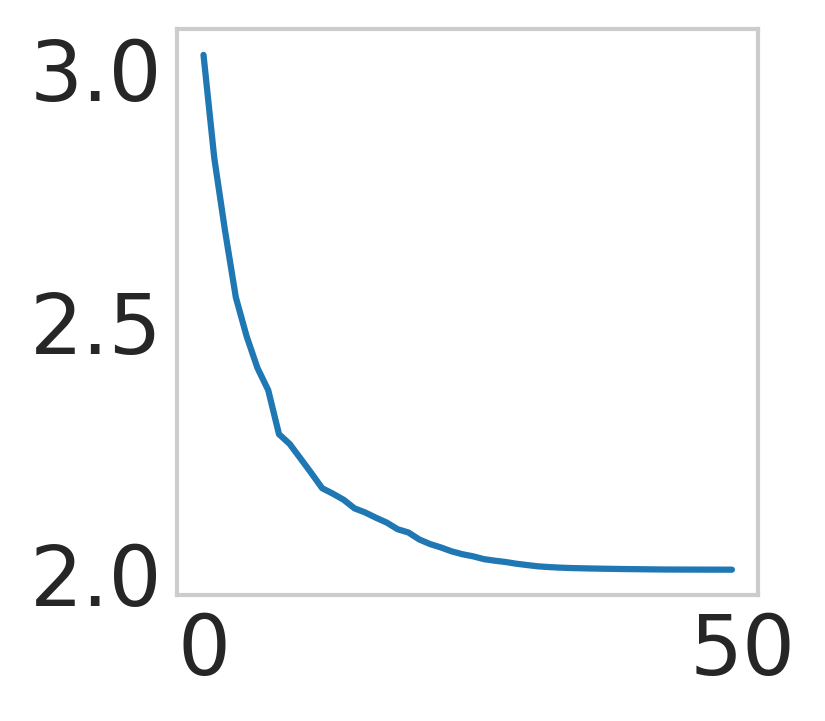

In [55]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(2.5,2.5), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(mse_scores)
    ax.grid(False)
# plt.xticks(np.arange(0,31,10))
# plt.yticks(np.arange(0,1.7,.4))

# Create Model with Avg LASSO Coeffs

[back to top](#top)

In [52]:
###LOAD THE MODEL
model = pd.read_pickle('bootstrap_coefficient_estimates_top_sorted')
model2 = model.abs()
df = model2.T.sort_values(by=0, ascending=False).iloc[:11]
cols = df.T.columns.tolist()
model = model[cols]
cols = model.columns.tolist()
cols.append("Density_kg/m")

###LOAD THE DATA AND REMOVE FEATURES NOT IN MODEL
datadf = pd.read_pickle('density_centered_scaled')
datadf = datadf.reset_index(drop=True)
# datadf = datadf.loc[~datadf["NAME_CAT"].str.contains("imidazolium", case=False)]
datadf = datadf.iloc[:,:].sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
df = datadf.T.loc[cols]

data=np.array(df.T)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = 0#int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

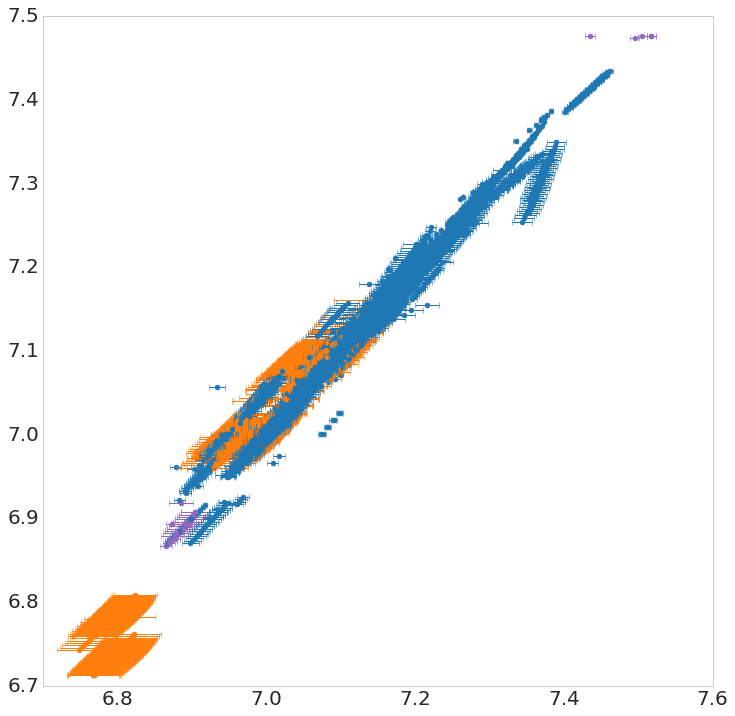

In [61]:
colors=[]
df = pd.DataFrame(catlist)
for i in range(len(X_test)):
    if df.loc[i].str.contains("imidazolium", case=False)[0]:
        colors.append(tableau20[0])
    elif df.loc[i].str.contains("phosphonium", case=False)[0]:    
        colors.append(tableau20[2])
    elif df.loc[i].str.contains("pyridinium", case=False)[0]:    
        colors.append(tableau20[4])
    elif df.loc[i].str.contains("pyrrolidinium", case=False)[0]:    
        colors.append(tableau20[6])
    else:
        colors.append(tableau20[8])
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(12,12), dpi=300)
    ax=fig.add_subplot(111)
    for i in range(len(Y_test)):
        ax.errorbar( Y_test[i],np.dot(X_test[i], model.loc[0])+\
            np.mean(Y_test[:] - np.dot(X_test[:], model.loc[0])),xerr=\
            np.dot(X_test[i], model.loc[1]),marker=".",linestyle="",color=colors[i])
#     ax.plot(np.arange(-6,1,0.0001),np.arange(-6,1,0.0001),color = 'black')
    plt.grid(False)

<a id='lasso'></a>

# Train LASSO

[back to top](#top)

In [218]:
datadf = pd.read_pickle('density_centered_scaled')
datadf = datadf.reset_index(drop=True)
# datadf = datadf.loc[~datadf["NAME_CAT"].str.contains("imidazolium", case=False)]
datadf = datadf.iloc[:,:].sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = np.log(data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1].astype(float))

In [232]:
pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
devmodel = pickle.load(pickle_in)
df = devmodel.Data
df = df.sample(frac=1)
metaDf = df.select_dtypes(include=["object"])
dataDf = df.select_dtypes(include=[np.number])
n = int(dataDf.shape[0]*0.8)
X_train = dataDf.values[:n]
Y_train = metaDf["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))[:n]
X_test = dataDf.values[n:]
Y_test = metaDf["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))[n:]

In [233]:
model = Lasso(alpha=0.0005,tol=1e-20, max_iter=1e5)
model.fit(X_train,Y_train)

/home/wesley/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-20, warm_start=False)

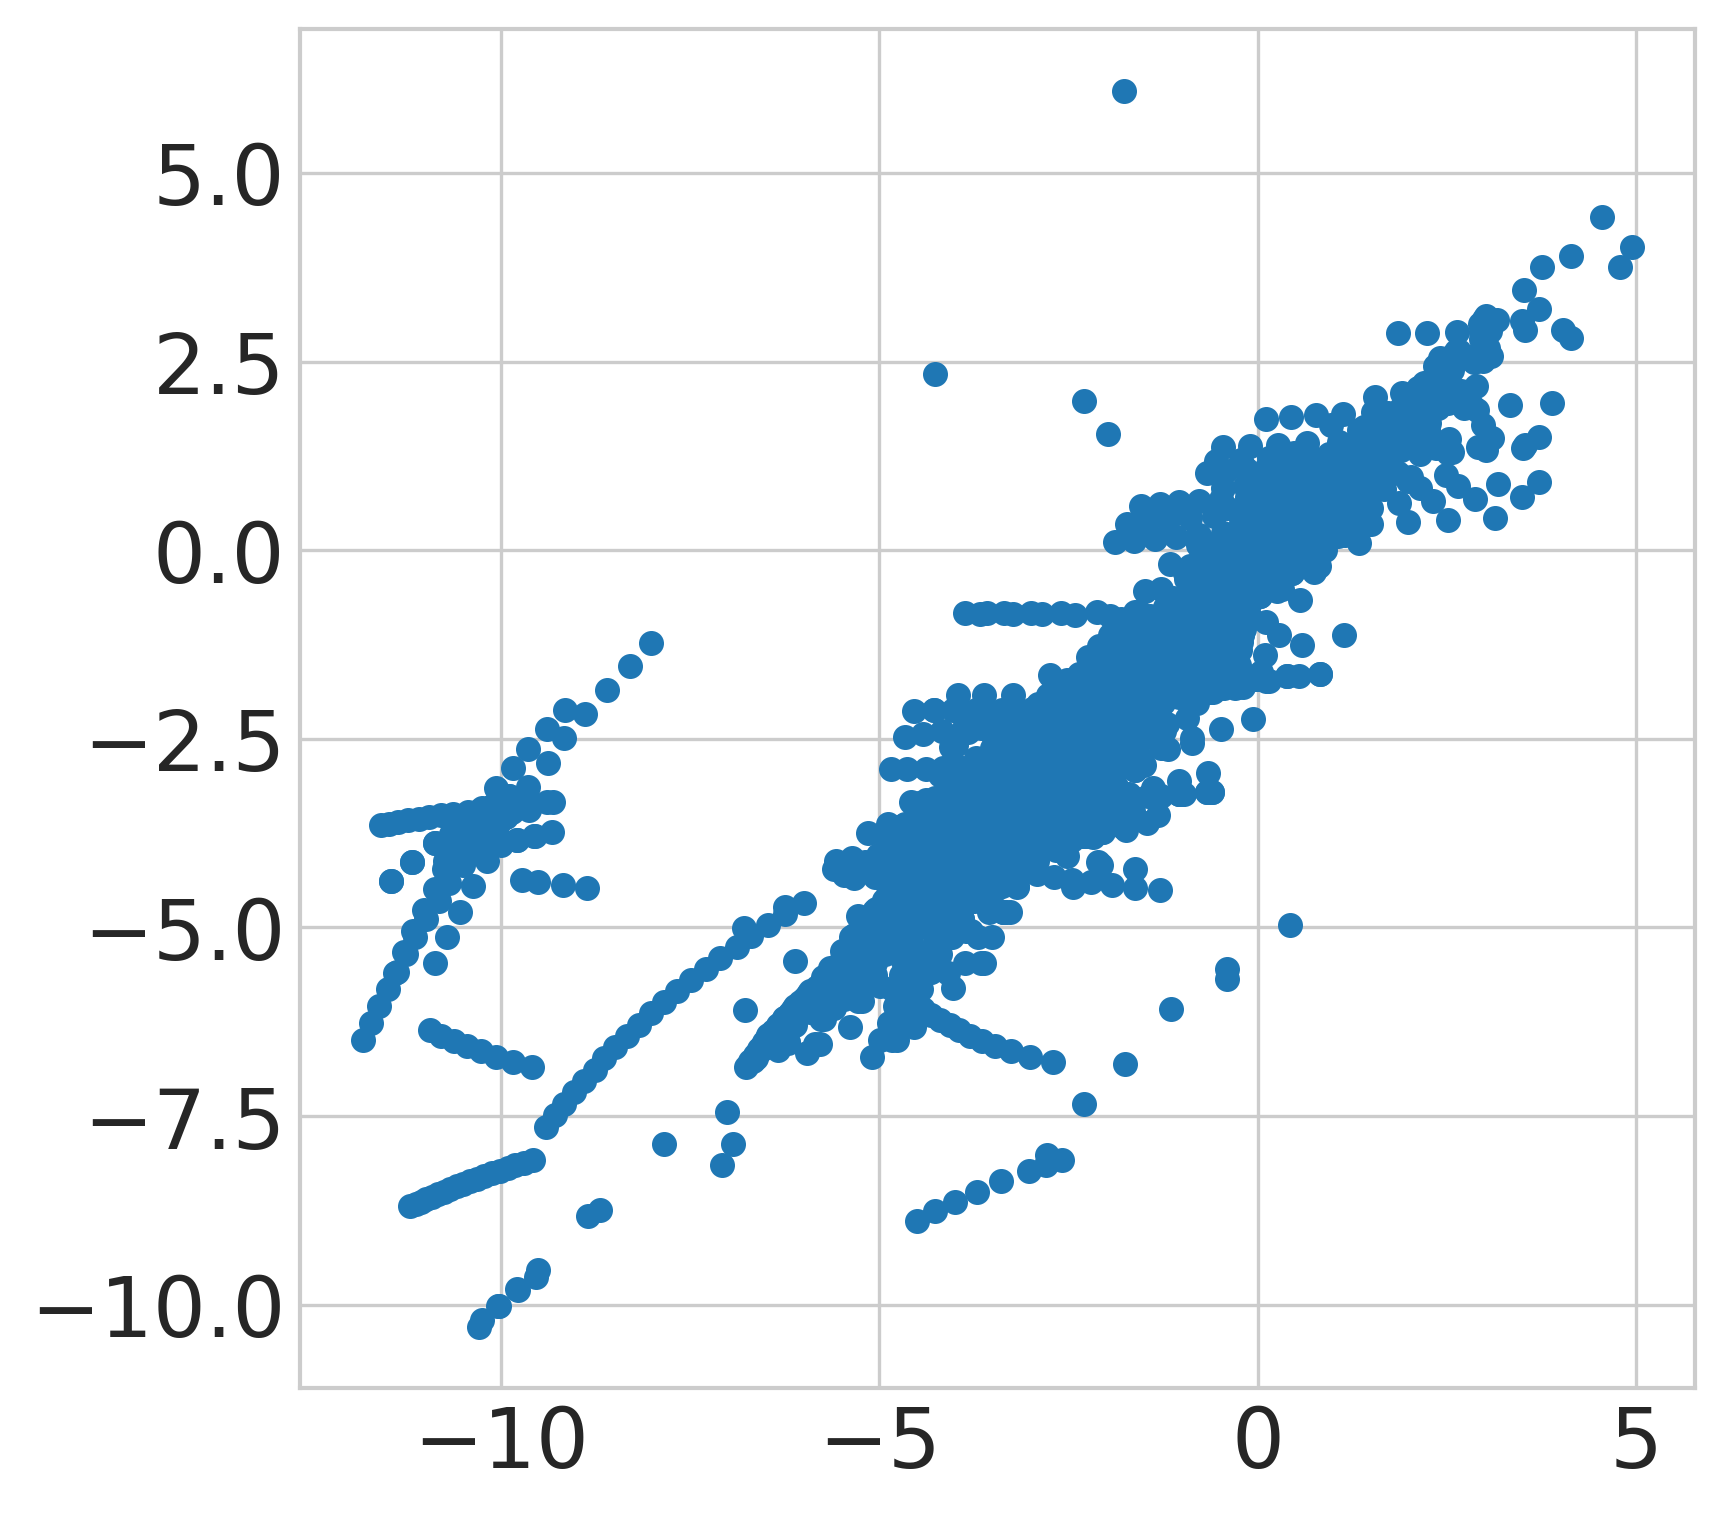

In [84]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    ax.plot(Y_train,model.predict(X_train),\
            marker=".",linestyle="")

In [34]:
f = open('../salty/data/Deslist','r')
deslist = []
for line in f:
    deslist.append(line.strip('\n\t'))
cols_cat = [s + "-cation" for s in deslist]
cols_ani = [s + "-anion" for s in deslist]
deslist = cols_cat + cols_ani + ["Temperature_K" , "Pressure_kPa", "Density_kg/m"]

i=0
for a in range(len(deslist)-3):
    if model.coef_[a] != 0:
        print(a, deslist[a])
        i+=1
print(i)

(3, 'BertzCT-cation')
(8, 'Kappa3-cation')
(29, 'NumHDonors-cation')
(76, 'EState_VSA5-cation')
(78, 'EState_VSA7-cation')
(96, 'BalabanJ-anion')
(99, 'HallKierAlpha-anion')
(102, 'Kappa3-anion')
(119, 'HeavyAtomMolWt-anion')
(136, 'PEOE_VSA7-anion')
(140, 'PEOE_VSA11-anion')
(144, 'SMR_VSA1-anion')
(158, 'SlogP_VSA5-anion')
(168, 'EState_VSA3-anion')
(170, 'EState_VSA5-anion')
(173, 'EState_VSA8-anion')
(186, 'VSA_EState10-anion')
17


In [ ]:
["Temperature_K" , "Pressure_kPa", "Density_kg/m"]
X=Y_test
Y=model.predict(X_test)
to_save=pd.DataFrame(np.transpose([X,Y,labels,T,P]),columns=["Density_kg/m, Experimental",\
        "Density_kg/m, Prediction", "Salt Name", "Temperature_K" , "Pressure_kPa"])

In [ ]:
pd.DataFrame.to_csv(to_save, path_or_buf='../salty/data/data_2_d3_Press_Temp.csv', index=False)

<a id='nn'></a>

# MLPRegressor

[back to top](#top)

In [71]:
####Create dataset according to LASSO selected features
select_score = np.load("LASSOSelectionScores.npy")
select_deslist = np.load("LASSOSelectionList.npy")
df = pd.DataFrame(select_score, select_deslist)
df = df.sort_values(by=0, ascending=False)
avg_selected_features=20
df = df.iloc[:avg_selected_features]
datadf = pd.read_pickle('density_centered_scaled')
###store data on coeffs
mean_std_of_coeffs = pd.read_pickle('density_mean_std_of_coeffs')
to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
cols = [col for col in datadf.columns if col in to_add]
coeffs = mean_std_of_coeffs[cols]


# datadf = datadf.loc[~datadf["NAME_CAT"].str.contains("imidazolium", case=False)]
datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
data = np.array(datadf)

to_add=[]
for i in range(len(df)):
    to_add.append(df.index[i])
# to_add.append("Density_kg/m")
cols = [col for col in datadf.columns if col in to_add]
# data = datadf[cols]
# data=np.array(data)

# cols.append("Viscosity, Pas")
# property_model = "viscosity"
# pickle_in = open("../salty/data/%s_devmodel.pkl" % property_model, "rb")
# devmodel = pickle.load(pickle_in)
# df = devmodel.Data
# df = df.sample(frac=1)
# df["Viscosity, Pas"] = df["Viscosity, Pas"].str.split().apply(lambda x: log(float(x[0])))
# metadf = df.select_dtypes(include=["object"])
# datadf = df.select_dtypes(include=[np.number])
# df = datadf.T.loc[cols]
# data=np.array(df.T)


n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8) #set fraction of data to be for training
n_test  = n - n_train

#data = np.random.permutation(data) #if you delete, will not be random ie separate by group
X_train = np.zeros((n_train,d)) #prepare train/test arrays
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))
X_train[:] = data[:n_train,:-1] #fill arrays according to train/test split
Y_train[:] = (data[:n_train,-1].astype(float))
X_test[:] = data[n_train:,:-1]
Y_test[:] = (data[n_train:,-1].astype(float))

In [69]:
X_train.dtype

dtype('float64')

In [72]:
###optimization w/ 100 nodes in hidden layer
model = MLPRegressor(activation='logistic', alpha=0.92078, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=75, learning_rate='constant',
       learning_rate_init=0.001, max_iter=1e8, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-08, validation_fraction=0.1,
       verbose=False, warm_start=False)
model.fit(X_train,Y_train)

TypeError: 'float' object cannot be interpreted as an integer

In [37]:
coeffs.to_csv("density_nn_model_descriptors.csv", index=False)

In [8]:
file = open("density_nn_model_descriptors", "w")
for item in cols:
    file.write("%s\n" % item)

In [41]:
pickle.dump(model, open("density_nn_model.sav", 'wb'))

In [16]:
data_file_name = "density_nn_model.sav"
with open((data_file_name), 'rb') as \
                pickle_file:
            data = pickle.load(pickle_file)
model = data

In [23]:
max(np.exp(Y_test))

1818.2999999999995

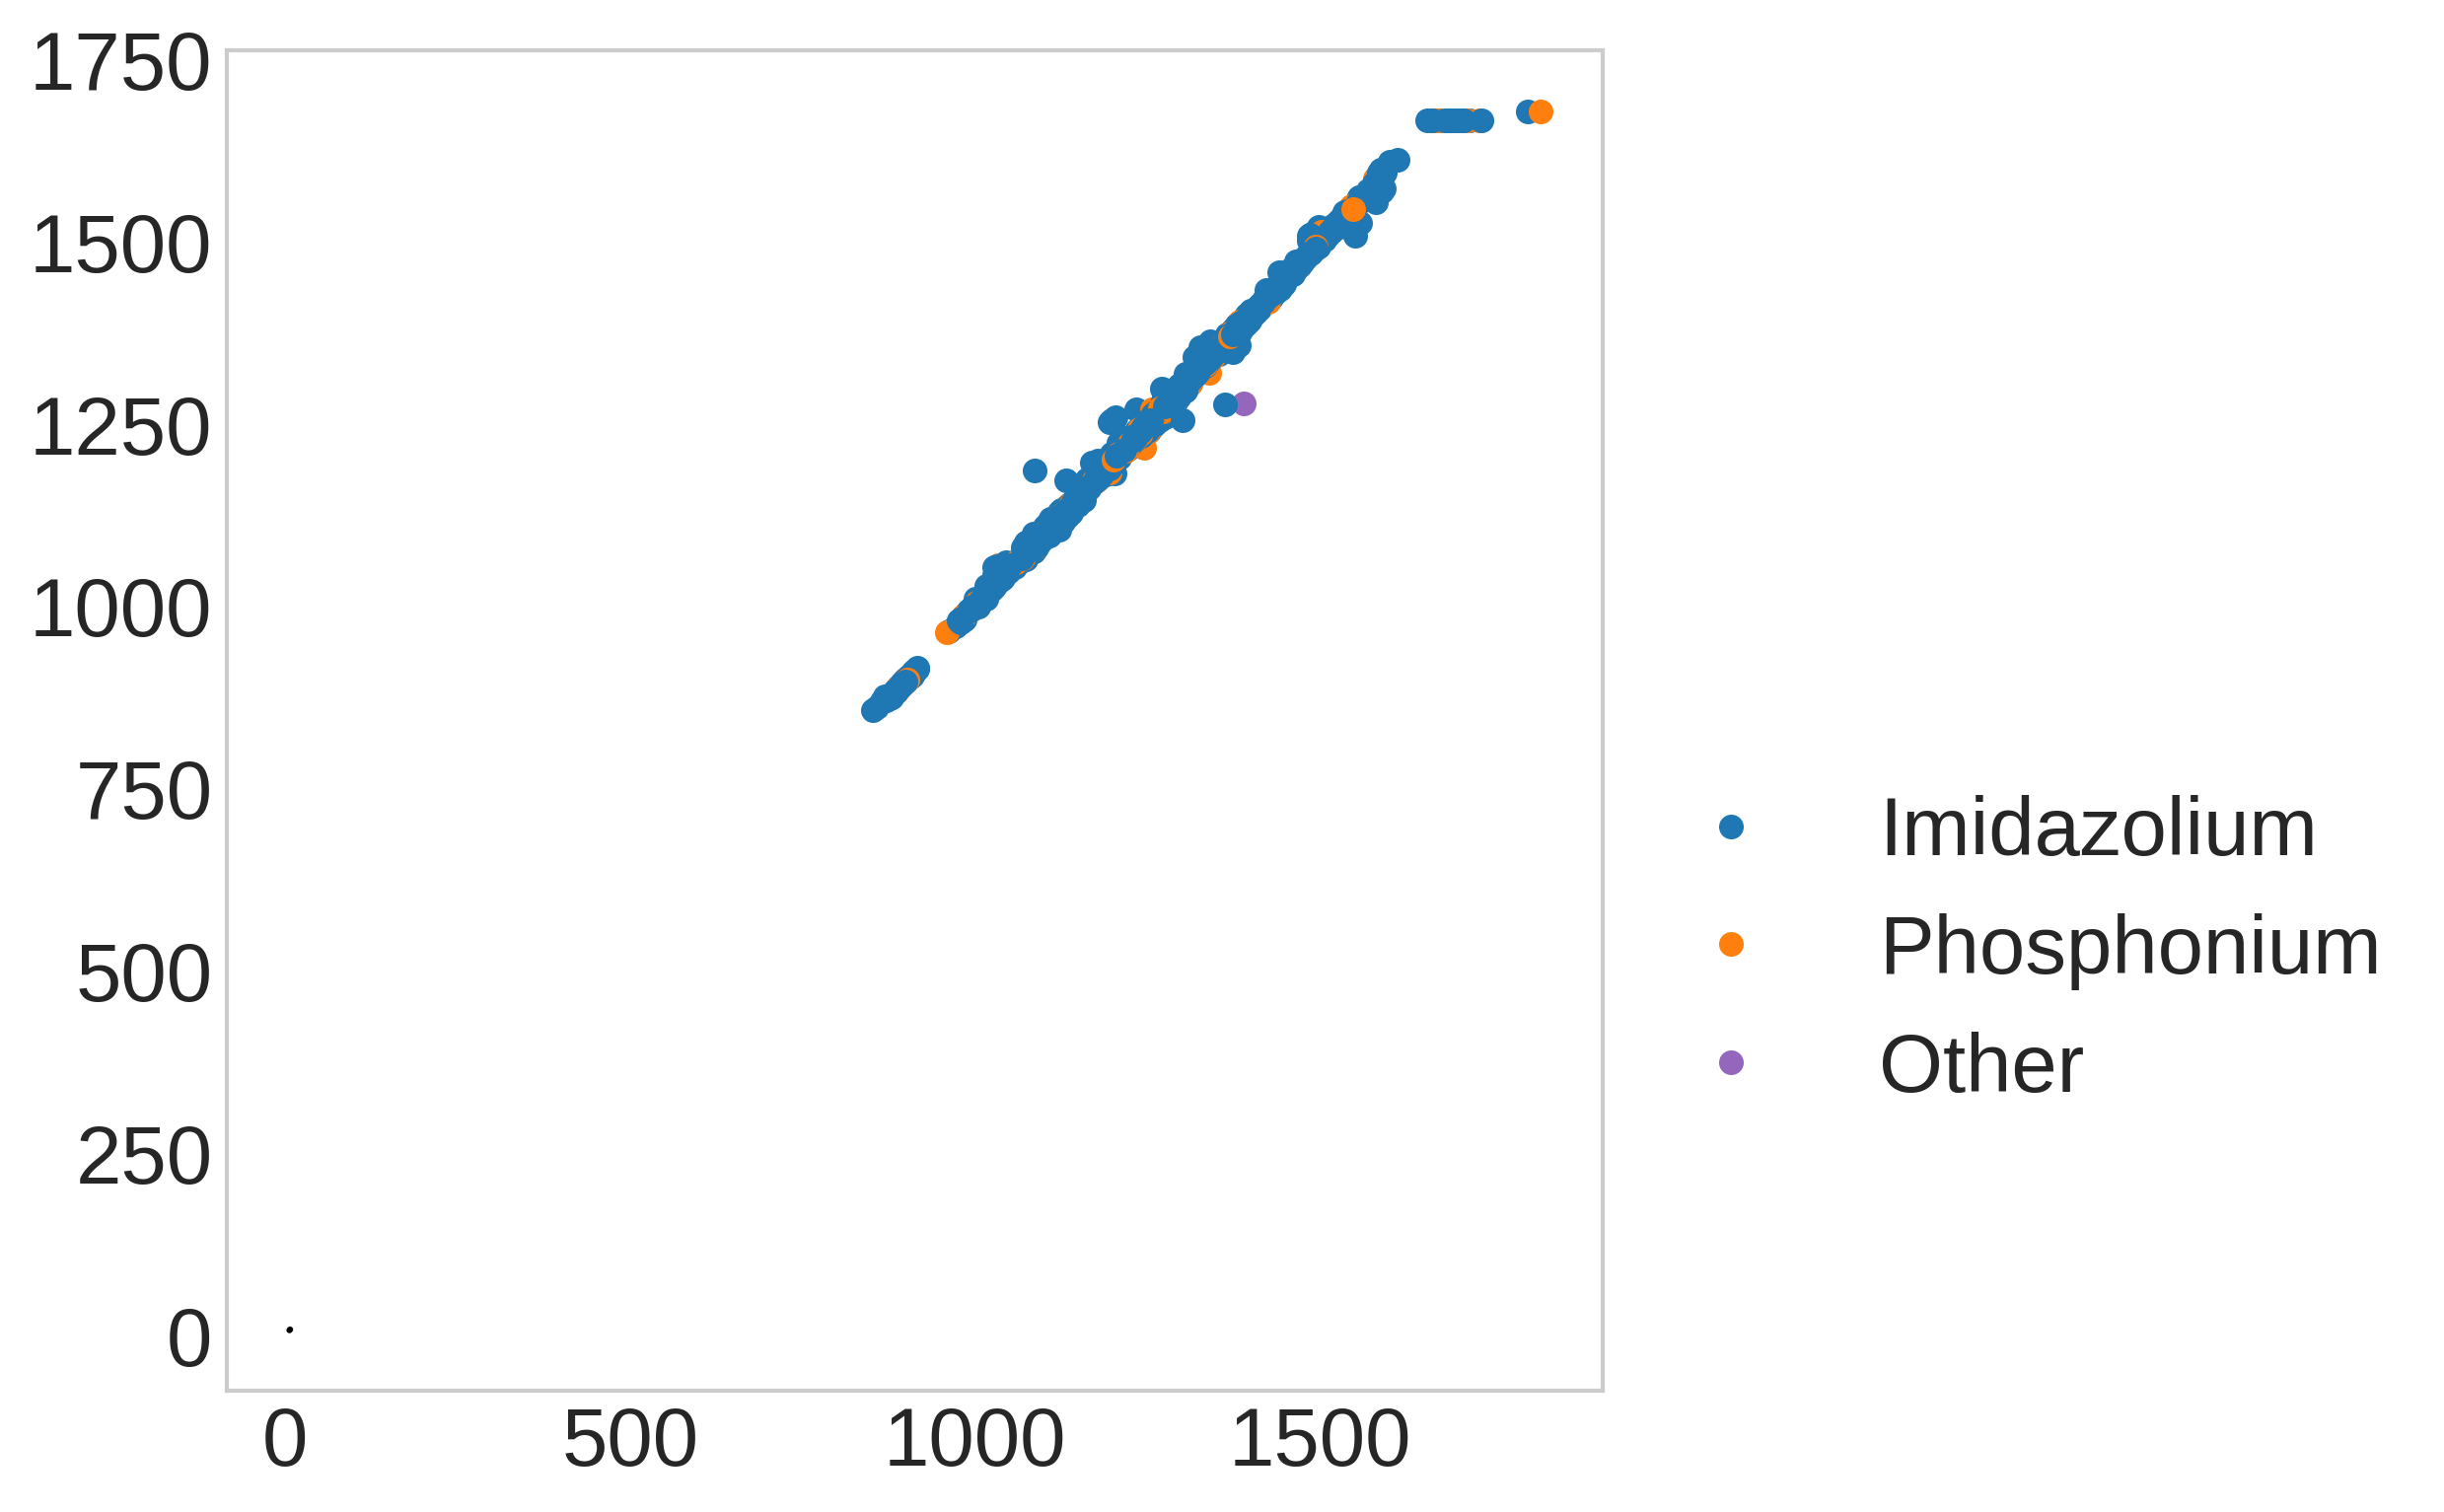

In [64]:
###COLOR BY SALT TYPE
from math import exp
colors=[]
labels=[]
df = pd.DataFrame(catlist)
for i in range(len(X_test)):
    if df.loc[i].str.contains("imidazolium", case=False)[0]:
        colors.append(tableau20[0])
        labels.append("Imidazolium")
    elif df.loc[i].str.contains("phosphonium", case=False)[0]:    
        colors.append(tableau20[2])
        labels.append("Phosphonium")
    elif df.loc[i].str.contains("pyridinium", case=False)[0]:    
        colors.append(tableau20[4])
        labels.append("Pyridinium")
    elif df.loc[i].str.contains("pyrrolidinium", case=False)[0]:    
        colors.append(tableau20[6])
        labels.append("Pyrrolidinium")
    else:
        colors.append(tableau20[8])
        labels.append("Other")
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(6,6), dpi=300)
    ax=fig.add_subplot(111)
    for i in range(len(Y_test)):
        ax.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),\
                marker=".",linestyle="",color=colors[i],\
                label=labels[i])
# colors=[]
# df_imid = pd.DataFrame(catlist_imid)
# for i in range(len(X_test_imid)):
#     if df_imid.loc[i].str.contains("imidazolium", case=False)[0]:
#         colors.append(tableau20[0])
#     elif df_imid.loc[i].str.contains("phosphonium", case=False)[0]:    
#         colors.append(tableau20[2])
#     elif df_imid.loc[i].str.contains("pyridinium", case=False)[0]:    
#         colors.append(tableau20[4])
#     elif df_imid.loc[i].str.contains("pyrrolidinium", case=False)[0]:    
#         colors.append(tableau20[6])
# with plt.style.context('seaborn-whitegrid'):
    
#     for i in range(len(Y_test_imid)):
#         ax.errorbar(Y_test_imid[i],model.predict(X_test_imid[i].reshape(1,-1)),\
#                 xerr=np.dot(X_test_imid[i], model3.loc[1]),marker=".",linestyle="",color=colors[i])
    ax.plot(np.arange(6.7,7.6,0.0001),np.arange(6.7,7.6,0.0001),color = 'black')
#     ax.axis([-6,1,-6,1])
    plt.grid(False)
#     plt.yticks(np.arange(-5,2,1))
#     plt.tick_params(axis='x', which='both', labelbottom='off')
#     plt.tick_params(axis='y', which='both', labelleft='off')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.62,0.5))
    plt.show()
# fig.savefig(filename='paper_images/Test_Dataset_Imid.eps', bbox_inches='tight', format='eps',\
#            transparent=True)  

<a id='static'></a>

# Create static files

[back to top](#top)

In [50]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 

def createArrays(datadf):
    data=np.array(datadf)
    n = data.shape[0]
    d = data.shape[1]
    d -= 1
    n_train = int(n*0.8)
    n_test  = n - n_train
    data = np.random.permutation(data)
    X_train = np.zeros((n_train,d))
    X_test  = np.zeros((n_test,d))
    Y_train = np.zeros((n_train))
    Y_test = np.zeros((n_test))
    X_train[:] = data[:n_train,:-1]
    Y_train[:] = np.log(data[:n_train,-1])
    X_test[:] = data[n_train:,:-1]
    Y_test[:] = np.log(data[n_train:,-1])
    return X_train, X_test, Y_train, Y_test

Temps = np.arange(200,(500+(500-200)/10),(500-200)/4)
Press = np.arange(0,210000+21000,210000/4)
Dens = np.arange(850,1850+100,(1850-850)/4)
Names = ["imidazolium", "phosphonium", "pyridinium", "pyrrolidinium", "ammonium"]
counter=0
df = pd.DataFrame()

for L in range(1, len(Names)+1):
    for subset in itertools.combinations(Names, L):
        for T_min_iter, T_min in enumerate(Temps):
            for T_max_iter in range(len(Temps)-T_min_iter):
                one_salt = False
                two_salt = False
                three_salt = False
                four_salt = False
                ############
                #CREATE DF
                ############
                T_max = Temps[-T_max_iter-1]
                df.loc[counter,"T_min"]=T_min
                df.loc[counter,"T_max"]=T_max
                df.loc[counter,"Salt_type_1"]=subset[0]
                try:
                    df.loc[counter,"Salt_type_2"]=subset[1]
                except:
                    df.loc[counter,"Salt_type_2"]="Nan"
                try:
                    df.loc[counter,"Salt_type_3"]=subset[2]
                except:
                    df.loc[counter,"Salt_type_3"]="Nan"
                try:
                    df.loc[counter,"Salt_type_4"]=subset[3]
                except:
                    df.loc[counter,"Salt_type_4"]="Nan"
                try:
                    df.loc[counter,"Salt_type_4"]=subset[4]
                except:
                    df.loc[counter,"Salt_type_4"]="Nan"
                ############
                #CREATE DF FOR TRAINING
                ############
                datadf1 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[0], case=False)] #create subset
                try:
                    datadf2 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[1], case=False)] #create subset
                except:
                    one_salt=True
                    pass
                try:
                    datadf3 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[2], case=False)] #create subset
                except:
                    two_salt=True
                    pass
                try:
                    datadf4 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[3], case=False)] #create subset
                except:
                    three_salt=True
                    pass
                try:
                    datadf5 = datadf.loc[datadf["NAME_CAT"].str.contains("%s" % subset[4], case=False)] #create subset
                except:
                    four_salt=True
                    pass
                if one_salt == True:
                    anilist = datadf['NAME_ANI']
                    catlist = datadf['NAME_CAT']
                    datadf1 = datadf1.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
                    datadf1 = datadf1.drop('NAME_ANI',1)
                    datadf1 = datadf1.drop("salt_name",1)
                    
                counter+=1
                
                
                
#                 for P_min_iter, P_min in enumerate(Press):
#                     for P_max_iter in range(len(Press)-P_min_iter):
#                         P_max = Press[-P_max_iter-1]
#                         for D_min_iter, D_min in enumerate(Dens):
#                             for D_max_iter in range(len(Dens)-D_min_iter):
#                                 D_max = Dens[-D_max_iter-1]                
#                                 print(subset)
#                                 print("T_min=%s" % T_min + " T_max=%s" % T_max + \
#                                       " P_min=%s" % P_min + " P_max=%s" % P_max + \
#                                       " D_min=%s" % D_min + " D_max=%s" % D_max)
#                                 counter+=1